In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import contractions


from time import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
df = pd.read_csv('./datasets/test_filtered_data.csv')

In [15]:
embedding_dim = 300    # Dimensions used for glove6b100
max_length = 50   # Maximum size of a tweet
trunc_type='post'      # Truncates the tweet if it is longer than max_length
padding_type='post'    # Adds padding to the end of the tweet if it is shorter than max_length
oov_tok = "<OOV>"      # Token "<OOV>" replaces words that are not part of the vocabulary (Out Of Vocabulary)
training_size=len(df)
test_portion=.15

In [16]:
comments = df['comment_text']
# y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'isToxic']]
y = df['isToxic']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(comments, y, test_size=test_portion)

In [18]:
# y_train_isToxic = y_train['isToxic']
# y_train = y_train.drop(columns=['isToxic'])

# y_test_isToxic = y_test['isToxic']
# y_test = y_test.drop(columns=['isToxic'])

In [19]:
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    oov_token=oov_tok,
)

In [20]:
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)


In [21]:
sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [22]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
word_index = tokenizer.word_index
vocab_size = len(word_index)

In [24]:

embeddings_index = {}
f = open('./Glove/glove.6B.300d.txt','r',encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [25]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
input_dimension = vocab_size + 1

model = Sequential()
model.add(Embedding(input_dimension, 300, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid')) 

2024-03-13 12:03:43.419844: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:43.426589: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:43.426637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:44.111996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:44.112605: I external/local_xla/xla/stream_executor

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [28]:
from sklearn.utils import compute_sample_weight

sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
# sample_weights[y_train_isToxic == 1] *= 1.5

In [29]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=1.0)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

2024-03-13 12:03:58.081413: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:58.081678: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:58.081717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:58.083068: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 12:03:58.083112: I tensorflow/core/common_runtime/gpu/gpu

In [30]:
history = model.fit(
    padded_sequences, 
    y_train, 
    epochs=5, 
    validation_data=(test_padded_sequences, y_test),
    sample_weight=sample_weights,
    batch_size=128
)
print("Training Complete")

Epoch 1/5


2024-03-13 12:04:09.113467: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd674811510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 12:04:09.113512: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-03-13 12:04:09.158778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-13 12:04:09.239631: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1710327849.350503  175415 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - 36s 249ms/step - loss: 0.5439 - accuracy: 0.6358 - val_loss: 0.4732 - val_accuracy: 0.8356
Epoch 2/5
100/100 [==============================] - 24s 237ms/step - loss: 0.3510 - accuracy: 0.8555 - val_loss: 0.2918 - val_accuracy: 0.9236
Epoch 3/5
100/100 [==============================] - 25s 248ms/step - loss: 0.2919 - accuracy: 0.8765 - val_loss: 0.3664 - val_accuracy: 0.8320
Epoch 4/5
100/100 [==============================] - 22s 221ms/step - loss: 0.2711 - accuracy: 0.8904 - val_loss: 0.2845 - val_accuracy: 0.8751
Epoch 5/5
100/100 [==============================] - 23s 228ms/step - loss: 0.2374 - accuracy: 0.8887 - val_loss: 0.2337 - val_accuracy: 0.9173
Training Complete


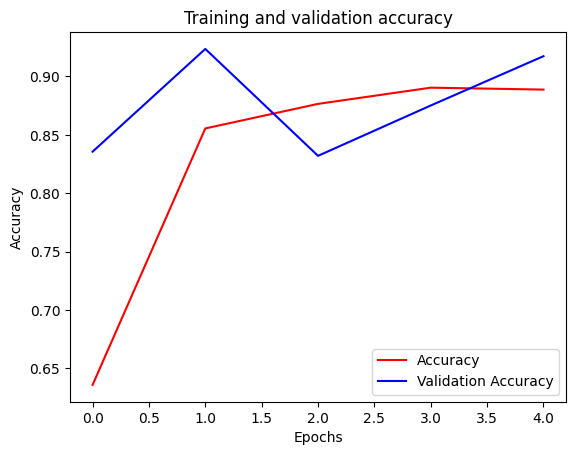

<Figure size 640x480 with 0 Axes>

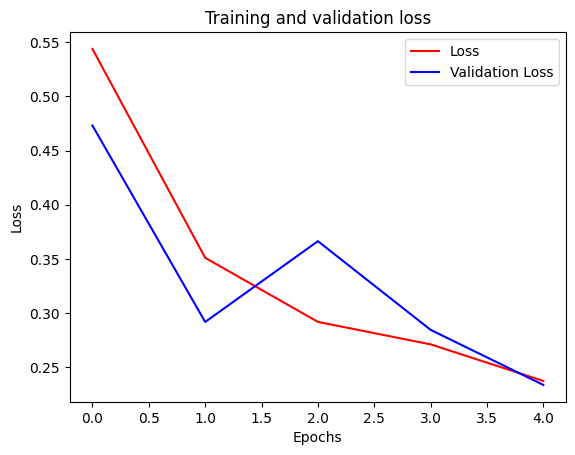

<Figure size 640x480 with 0 Axes>

In [31]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()
plt.show()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()

In [32]:
def get_indices_above_threshold(pred, threshold=0.5):
    indices = [index for index, value in enumerate(pred) if value > threshold]
    return indices

In [33]:
i = 0

In [34]:
ph = df[df['isToxic'] == 1].iloc[i]

phrase = [ph['comment_text']]
print(phrase)

tokenizer.fit_on_texts(phrase)
sequences_phrase = tokenizer.texts_to_sequences(phrase)
print(sequences_phrase)
padded_sequences_phrase = pad_sequences(sequences_phrase, maxlen=max_length, padding=padding_type, truncating=trunc_type)

pred = model.predict(padded_sequences_phrase)
print(pred)
# print("------")
# if (pred[0][0] > 0.5):
#     print("Toxic")
# if (pred[0][1] > 0.5):
#     print("Severe Toxic")
# if (pred[0][2] > 0.5):
#     print("Obscene")
# if (pred[0][3] > 0.5):
#     print("Threat")
# if (pred[0][4] > 0.5):
#     print("Insult")
# if (pred[0][5] > 0.5):
#     print("Identity Hate")
# print("------")


i += 1

print(ph)


['huh actually according wpporn issue image deleted back summary image would trigger record keeping requirements while name image creampiesexjpg obviously form explicit sexual material wonder line drawn comes penis images suppose time ask someone foundation —¢δs actually upon investigation past discussions would seem images probably restricted for example discussion erection probably ejaculation might —¢δs many pics one pic enough properly show part male anatomy feel article bit excessive displaying penis also consider many pics might discourage readers viewing article exclusively human nonhuman penises received fleeting mention there needs function physiology penises animals']
[[2581, 140, 452, 20287, 168, 61, 65, 73, 434, 61, 9, 5417, 625, 1083, 2129, 723, 35, 61, 20288, 398, 507, 4172, 1868, 253, 1057, 379, 4449, 642, 2053, 242, 1359, 13, 113, 67, 1598, 11448, 140, 819, 2271, 443, 783, 9, 262, 242, 199, 3051, 132, 209, 58, 20289, 199, 20290, 99, 11448, 44, 3282, 8, 2244, 211, 882, 1

In [35]:
# Inverser le dictionnaire de mots
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# Récupérer le mot pour l'ID 1
word = reverse_word_index.get(1)
print(word)

<OOV>
